RuntimeError: No active exception to reraise

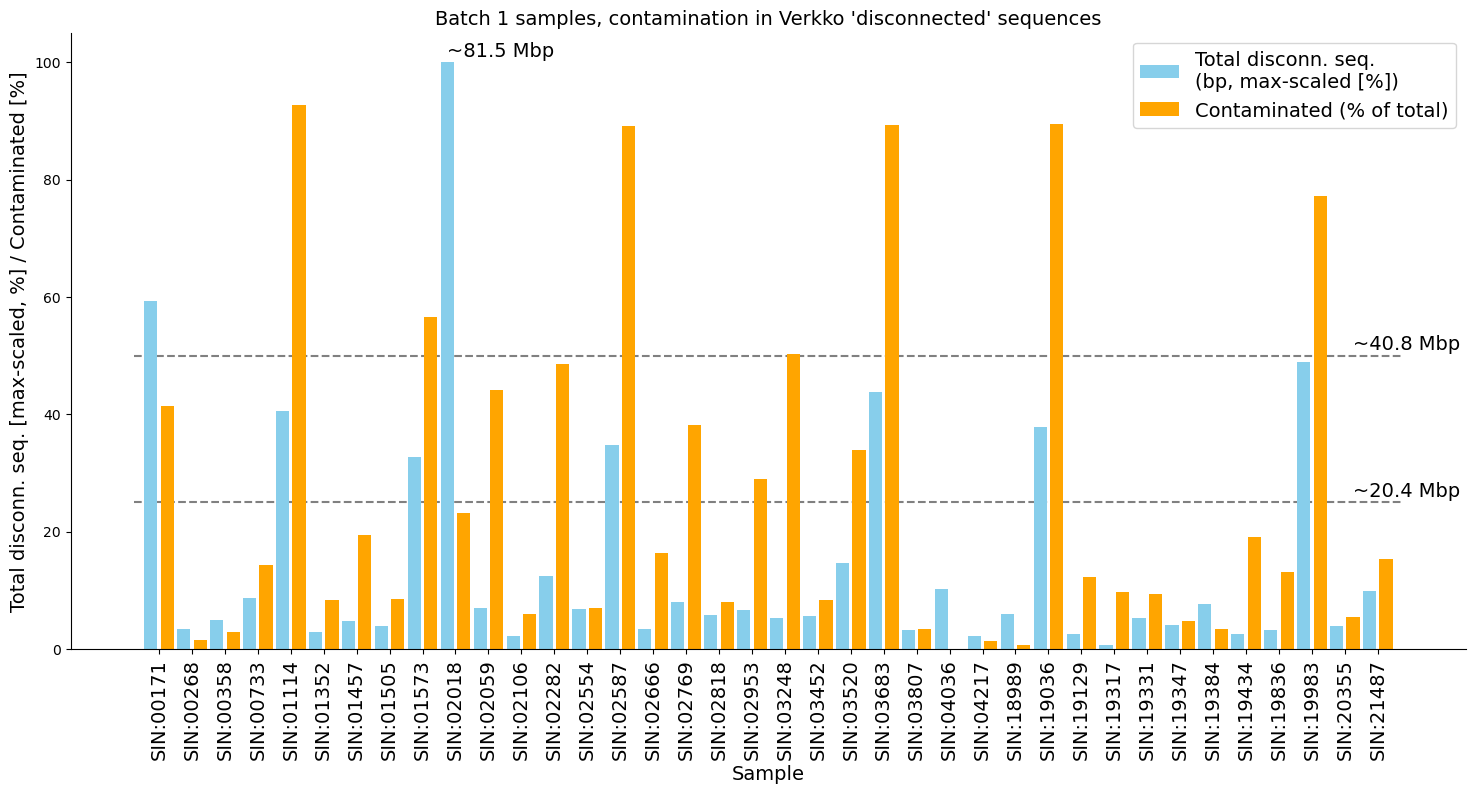

In [120]:
import pandas as pd
import pathlib as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
import random as rand
import collections as col
import numpy as np

rand.seed()

contam_stats_path = pl.Path(
    "/home/ebertp/work/projects/hgsvc/2023_assm_stats/verkko/contamination"
)

# 2023-07-27 ignore residual adaptors,
# only NA20355 has 39 bp PacBio adaptor
# in one unassigned contig
gx_stats = []
for contam_file in contam_stats_path.glob("*.fcs-report-contam.stats.tsv"):
    sample, asm_type, _ = contam_file.name.split(".", 2)
    asm_unit = asm_type.split("-")[-1]
    sin = "SIN:" + sample[2:]
    
    df = pd.read_csv(contam_file, sep="\t", header=0, comment="#")
    df["sample"] = sample
    df["SIN"] = sin
    df["asm_unit"] = asm_unit
    gx_stats.append(df)
    
gx_stats = pd.concat(gx_stats, axis=0, ignore_index=False)
gx_stats.index = gx_stats["SIN"]


sample_contam_file = pl.Path(
    "/home/ebertp/work/code/cubi/project-run-hgsvc-hybrid-assemblies/annotations/projectmng",
    "hgsvc_contaminations.tsv"
)

sample_contam = pd.read_csv(sample_contam_file, sep="\t", comment="#", header=0)
sample_contam["SIN"] = "SIN:" + sample_contam["sample"].str.extract("([0-9]+)")
sample_contam = sample_contam.loc[sample_contam["SIN"].isin(gx_stats["SIN"]), :].copy()

sample_contam.index = sample_contam["SIN"]
sample_contam.drop(["sample", "SIN"], axis=1, inplace=True)
gx_stats.drop(["SIN", "sample"], axis=1, inplace=True)

merged = sample_contam.join(gx_stats, how="outer")

def plot_stacked_bar_chart(subset, outfile=None):

    row_to_group = subset.loc[subset["statistic"] == "seq_length", ["group", "value"]].groupby("group").sum()
    row_to_group.sort_values("value", ascending=True, inplace=True)
    row_to_group.reset_index(drop=False, inplace=True)
    row_to_group = dict((row.Index, row.group) for row in row_to_group.itertuples())
    group_to_row = dict((v, k) for k, v in row_to_group.items())

    bar_heights = np.zeros((subset["group"].nunique(), subset.index.nunique()), dtype=float)
    avg_length = np.zeros(subset.index.nunique(), dtype=int)
    x_labels = []
    pos = 0
    for sin, stats in subset.groupby("SIN"):

        for group, group_stats in stats.groupby("group"):
            tot_len = int(group_stats.loc[group_stats["statistic"] == "seq_length", "value"].iloc[0])
            num_seq = int(group_stats.loc[group_stats["statistic"] == "num_sequences", "value"].iloc[0])
            bar_heights[group_to_row[group], pos] += round(np.log10(tot_len), 2)
            avg_length[pos] += tot_len/num_seq
        x_labels.append(sin.strip())
        pos += 1

    # plot total amount of affected sequence

    fig, ax = plt.subplots(figsize=(14, 8))

    colors = {
        3: "skyblue",
        2: "orange",
        1: "purple",
        0: "black"
    }
    bottom = np.zeros(subset.index.nunique(), dtype=float)
    for row_idx in range(bar_heights.shape[0]):
        heights = bar_heights[row_idx, :] - bottom
        heights = heights.clip(0, heights.max())
        ax.bar(
            np.arange(1, avg_length.size + 1),
            height=heights,
            color=colors[row_idx],
            label=row_to_group[row_idx],
            bottom=bottom
        )
        bottom += (bar_heights[row_idx, :] - bottom)

    ax.set_ylim(0, 9)
    ax.set_xlim(-0.5, bottom.size + 1)
    ax.set_xlabel("Samples", fontsize=14)
    ax.set_ylabel("Total affected length [ log10 (bp) ]", fontsize=14)
    ax.set_xticks(np.arange(1, avg_length.size + 1))
    ax.set_xticklabels(x_labels, rotation=90, fontsize=12)

    ax.legend(loc="best")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title("Batch 1 samples, contamination in Verkko 'unassigned' sequences", fontsize=14)

    ax.hlines([6, 7], -0.5, bottom.size, color="grey", linestyle="dotted", zorder=0)
    
    return


def plot_relative_abundance(subset, outfile=None):
    
    max_total = subset.loc[subset["statistic"] == "seq_length", "value"].max()
    
    scaled_totals = []
    pct_contam = []
    x_labels = []

    for sin, stats in subset.groupby("SIN"):
        get_len = stats["statistic"] == "seq_length"
        get_total = stats["action"] == "TOTAL"
        get_other = stats["action"] != "TOTAL"
        get_pct = stats["statistic"] == "pct_total_seq_length"
        total_seq_len = int(stats.loc[get_total & get_len, "value"].iloc[0])
        scaled_seq_len = round(total_seq_len/max_total*100, 2)
        agg_pct = round(stats.loc[get_other & get_pct, "value"].sum(), 2)
        
        scaled_totals.append(scaled_seq_len)
        pct_contam.append(agg_pct)
        
        x_labels.append(sin)
    
    pos_totals = np.arange(1, len(x_labels) * 2 + 1, step=2, dtype=int)
    pos_contam = np.arange(2, len(x_labels) * 2 + 2, step=2, dtype=int)
    pos_xticks = (pos_totals + pos_contam) / 2
    assert pos_totals.size == pos_contam.size == pos_xticks.size
    pos_totals = pos_totals[:len(scaled_totals)]
    pos_contam = pos_contam[:len(pos_contam)]
    
    fig, ax = plt.subplots(figsize=(18, 8))
    
    ax.bar(
        pos_totals,
        scaled_totals,
        color="skyblue",
        label="Total disconn. seq.\n(bp, max-scaled [%])"
    )
    
    ax.bar(
        pos_contam,
        pct_contam,
        color="orange",
        label="Contaminated (% of total)"
    )
    
    pct_100_length = round(max_total / 1e6, 1)
    pct_50_length = round(max_total * 0.5 / 1e6, 1)
    pct_25_length = round(max_total * 0.25 / 1e6, 1)
        
    ax.hlines(
        [50, 25],
        0, pos_contam[-1] + 1, color="grey",
        linestyle="dashed", zorder=0
    )
    
    ax.text(19, 101, f"~{pct_100_length} Mbp", fontsize=14)
    ax.text(74, 51, f"~{pct_50_length} Mbp", fontsize=14)
    ax.text(74, 26, f"~{pct_25_length} Mbp", fontsize=14)
    
    ax.set_xticks(pos_xticks)
    ax.set_xticklabels(x_labels, rotation=90, fontsize=14)
    
    ax.set_xlabel("Sample", fontsize=14)
    ax.set_ylabel("Total disconn. seq. [max-scaled, %] / Contaminated [%]", fontsize=14)
    ax.legend(loc="best", fontsize=14)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    ax.set_title(
        "Batch 1 samples, contamination in Verkko 'disconnected' sequences",
        fontsize=14
    )
    
        


# 2023-07-27
# since phasing is incomplete atm, the unassigned
# sequences also consist of contigs that will be
# phased; only makes sense to plot total contamination

# drop PASS/TOTAL
subset = merged.loc[~merged["action"].isin(["PASS", "TOTAL"]), :].copy()
# drop "any" group
subset = subset.loc[subset["group"] != "any", :].copy()
# select total length and num to compute avg. length
subset = subset.loc[subset["statistic"].isin(["seq_length", "num_sequences"]), :].copy()
# select unassigned
unassign = subset.loc[subset["asm_unit"] == "unassigned", :].copy()
#_ = plot_stacked_bar_chart(unassign)

# select disconnected
disconn = subset.loc[subset["asm_unit"] == "disconnected", :].copy()
#_ = plot_stacked_bar_chart(disconn)

# 2023-07-27
# for disconnected, looking at relative abundances
# makes sense since these seqs. cannot be brought
# back into the assembly process

# drop PASS/TOTAL
subset = merged.loc[~merged["action"].isin(["PASS"]), :].copy()
# drop "any" group
subset = subset.loc[subset["group"] == "any", :].copy()
# select total length and num to compute avg. length
subset = subset.loc[subset["statistic"].isin(["seq_length", "num_sequences", "pct_total_seq_length"]), :].copy()
disconn = subset.loc[subset["asm_unit"] == "disconnected", :].copy()

_ = plot_relative_abundance(disconn)

raise
    
# tick_locs = list(range(1,6))
# ticklabels = ["UW", "JAX", "UMIGS", "MIX", "EXT"]

# center_point_map = dict((label, loc) for label, loc in zip(ticklabels, tick_locs))

# fig, ax = plt.subplots(figsize=(8, 8))

# x_vals = []
# y_vals = []
# colors = []

# def add_jitter(point):
    
#     jitter = rand.uniform(-0.2, 0.2)
#     return round(point + jitter, 3), point

# center_probs = col.Counter()

# for row in sample_contam.itertuples(index=True):
#     x_coord, x_prec = add_jitter(center_point_map[row.hifi_center])
#     y_coord, y_prec = add_jitter(center_point_map[row.ont_center])
#     x_vals.append(x_coord)
#     y_vals.append(y_coord)
#     colors.append(color_lut[row.Index])
#     center_probs[(x_prec, y_prec)] += 1
    
# ax.scatter(
#     x_vals,
#     y_vals,
#     c=colors,
#     alpha=0.5
# )
# ax.set_xticks(tick_locs)
# ax.set_xticklabels(ticklabels, fontsize=10)
# ax.set_xlim(0, 5.1)

# ax.set_yticks(tick_locs)
# ax.set_yticklabels(ticklabels, fontsize=10)
# ax.set_ylim(0, 5.1)

# ax.vlines(tick_locs, 0.01, 5.01, colors="grey", linestyle="dotted", zorder=3)
# ax.hlines(tick_locs, 0.01, 5.01, colors="grey", linestyle="dotted", zorder=3)

# ax.set_xlabel("HiFi seq. center", fontsize=14)
# ax.set_ylabel("ONT seq. center", fontsize=14)

# print(center_probs)
# total_samples = sum(center_probs.values())

# for k, v in center_probs.items():
#     print(k, " - ", v, " --- ", round(v/total_samples*100, 1))